# Байесовская теория классификации

## Библиотеки

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from copy import deepcopy
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
from scipy import stats
import numpy as np
from sklearn import tree, base
import itertools
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, BaggingClassifier)
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.datasets import make_classification, make_regression, load_wine, load_boston, load_wine
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Принцип максимума правдоподобия

Если $P\bigr(y\bigr)$ равномерная случайная величина, то
$$
a\bigr(x\bigr) = \arg\max_{y\in Y} p\bigr(x|y\bigr)
$$

In [3]:
p_x_1 = stats.multivariate_normal([-1, -1], np.eye(2))
p_x_2 = stats.multivariate_normal([1, 1], 1.5*np.eye(2))

In [4]:
def plot():
    x = np.linspace(-3, 3, 300)
    y = np.linspace(-3, 3, 300)
    xs, ys = np.meshgrid(x, y)
    scores = [np.zeros_like(xs), np.zeros_like(xs)]
    for i in range(len(xs)):
        for j in range(len(xs[i])):
            scores[0][i][j] = p_x_1.pdf([xs[i][j],ys[i][j]])
            scores[1][i][j] = p_x_2.pdf([xs[i][j],ys[i][j]])

    ax = plt.figure(figsize=(14.0, 6.0)).gca(projection='3d')
    alpha=0.7
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] <= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] <= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] >= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] >= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.set_xlabel(r'x1', labelpad= 14), ax.set_ylabel(r'x2', labelpad=14)
    ax.set_zlabel(r'p(x)'), ax.view_init(30, -120)
    ax.view_init(30, -70)
    plt.show()

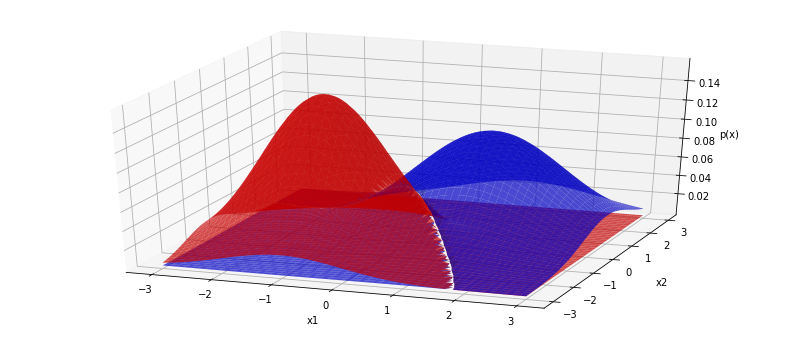

In [5]:
plot()

В случае, если плотности $p(x|y)$ заданы, то задача классификации является решенной. Но вопрос как найти $p(x|y)$?

## Одномерный случай

### Синтетические данные

Рассмотрим две гаусианы с разными средними и дисперсиями. Сгенерим выборку, где каждая гаусиана описывает свой класс.

In [6]:
np.random.seed(42)

l = 10000
p_x_1 = stats.norm(-1, 0.5)
x_1 = np.sqrt(0.5)*np.random.randn(l)-1
p_x_2 = stats.norm(1, 1.5)
x_2 = np.sqrt(1.5)*np.random.randn(l)+1

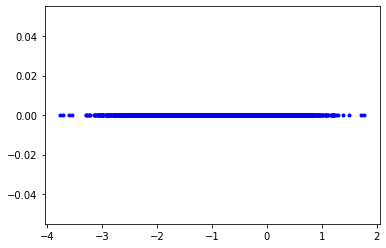

In [7]:
x = np.linspace(min(np.min(x_1), np.min(x_2)), 
                max(np.max(x_1), np.max(x_2)), 100)

plt.plot(x_1, x_1*0, '.', color='blue')
plt.show()

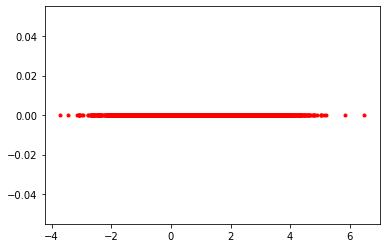

In [8]:
x = np.linspace(min(np.min(x_1), np.min(x_2)), 
                max(np.max(x_1), np.max(x_2)), 100)

plt.plot(x_2, x_2*0, '.', color='red')
plt.show()

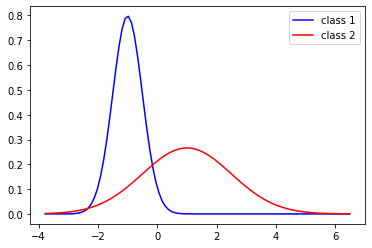

In [9]:
x = np.linspace(min(np.min(x_1), np.min(x_2)), 
                max(np.max(x_1), np.max(x_2)), 100)

plt.plot(x, p_x_1.pdf(x), color='blue', label='class 1')
plt.plot(x, p_x_2.pdf(x), color='red', label='class 2')
plt.legend(loc='best')
plt.show()

### Востановления плотности по эмпирическим данным
Истинное распределение $p(x|y)$ не известно, востановим данную плотность $\hat{p}(x|y, \mathbf{X})$.

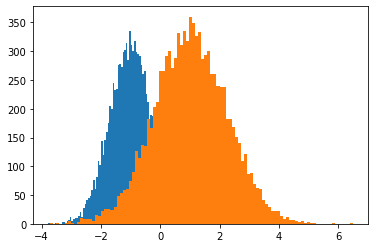

In [10]:
plt.hist(x_1, bins=100)
plt.hist(x_2, bins=100)

plt.show()

In [11]:
def p(x, D, h = 0.2):
    D = np.array(D)
    x = np.array(x)
    l = len(D)
    n = 1
    if len(D.shape) == 2:
        n = D.shape[1]
        
    D = D.reshape([-1, n])
    x = x.reshape([-1, n])
    return (1/(2*h))*(1/len(D))*(cdist(D, x, metric='minkowski', p=1) <= h).sum(axis=0)


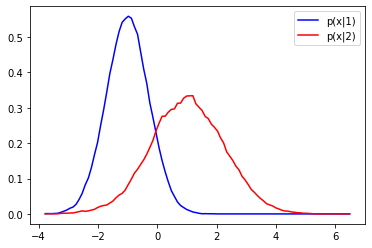

In [12]:
x = np.linspace(min(np.min(x_1), np.min(x_2)), 
                max(np.max(x_1), np.max(x_2)), 100)

plt.plot(x, p(x, x_1), color='blue', label='p(x|1)')
plt.plot(x, p(x, x_2), color='red', label='p(x|2)')
plt.legend(loc='best')
plt.show()

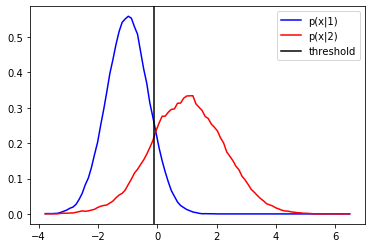

In [13]:
x = np.linspace(min(np.min(x_1), np.min(x_2)), 
                max(np.max(x_1), np.max(x_2)), 100)

plt.plot(x, p(x, x_1), color='blue', label='p(x|1)')
plt.plot(x, p(x, x_2), color='red', label='p(x|2)')

plt.axvline(-0.1, color='black', label='threshold')

plt.legend(loc='best')
plt.show()

### LOO для выбора ширины окна

In [14]:
def LOO(D, h):
    D_list = D.tolist()
    
    for i in range(len(D_list)):
        return -np.log(p([D_list[i]], D_list[:i]+D_list[i+1:], h)).sum()

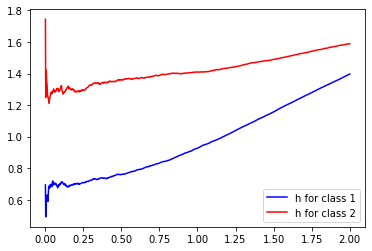

In [15]:
hs = np.linspace(1e-10, 2, 1000)
scores_1 = [LOO(x_1, h) for h in hs]
scores_2 = [LOO(x_2, h) for h in hs]

plt.plot(hs, scores_1, color='blue', label='h for class 1')
plt.plot(hs, scores_2, color='red', label='h for class 2')

plt.legend(loc='best')
plt.show()

In [16]:
hs[np.argmin(scores_1)], hs[np.argmin(scores_2)]

(0.0040040041038038035, 0.026026026124724728)

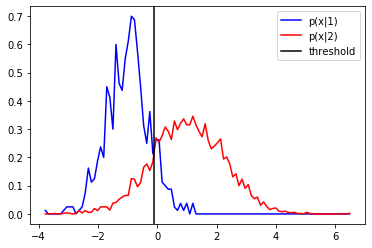

In [17]:
x = np.linspace(min(np.min(x_1), np.min(x_2)), 
                max(np.max(x_1), np.max(x_2)), 100)

plt.plot(x, p(x, x_1, hs[np.argmin(scores_1)]), color='blue', label='p(x|1)')
plt.plot(x, p(x, x_2, hs[np.argmin(scores_2)]), color='red', label='p(x|2)')

plt.axvline(-0.1, color='black', label='threshold')

plt.legend(loc='best')
plt.show()

## Двумерный случай

In [19]:
np.random.seed(42)

l = 10000
p_x_1 = stats.multivariate_normal([-1, -1], 0.5*np.eye(2))
x_1 = np.sqrt(0.5)*np.random.randn(l, 2)+np.array([-1, -1])

p_x_2 = stats.multivariate_normal([1, 1], 1.5*np.eye(2))
x_2 = np.sqrt(1.5)*np.random.randn(l, 2)+np.array([1, 1])

In [20]:
def plot():
    x = np.linspace(-3, 3, 300)
    y = np.linspace(-3, 3, 300)
    xs, ys = np.meshgrid(x, y)
    scores = [np.zeros_like(xs), np.zeros_like(xs)]
    for i in range(len(xs)):
        for j in range(len(xs[i])):
            scores[0][i][j] = p_x_1.pdf([xs[i][j],ys[i][j]])
            scores[1][i][j] = p_x_2.pdf([xs[i][j],ys[i][j]])

    ax = plt.figure(figsize=(14.0, 6.0)).gca(projection='3d')
    alpha=0.7
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] <= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] <= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] >= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] >= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.set_xlabel(r'x1', labelpad= 14), ax.set_ylabel(r'x2', labelpad=14)
    ax.set_zlabel(r'p(x)'), ax.view_init(30, -120)
    ax.view_init(30, -70)
    plt.show()

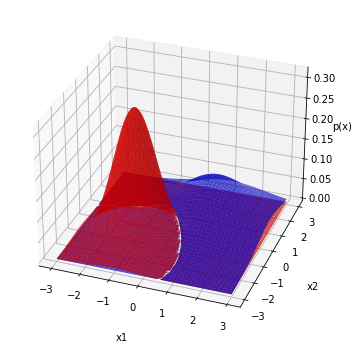

In [21]:
plot()

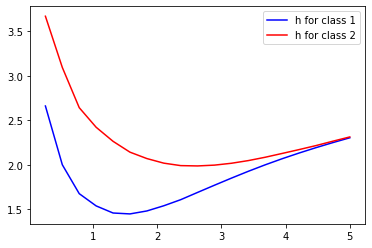

In [22]:
hs = np.linspace(1e-10, 5, 20)
scores_1 = [LOO(x_1, h) for h in hs]
scores_2 = [LOO(x_2, h) for h in hs]

plt.plot(hs, scores_1, color='blue', label='h for class 1')
plt.plot(hs, scores_2, color='red', label='h for class 2')

plt.legend(loc='best')
plt.show()

In [23]:
hs[np.argmin(scores_1)], hs[np.argmin(scores_2)]

(1.578947368489474, 2.6315789474157896)

In [24]:
def plot():
    x = np.linspace(-3, 3, 300)
    y = np.linspace(-3, 3, 300)
    xs, ys = np.meshgrid(x, y)
    scores = [np.zeros_like(xs), np.zeros_like(xs)]
    for i in range(len(xs)):
        line = np.array([[xs[i][j],ys[i][j]] for j in range(len(xs[i]))])
        scores[0][i] = p(line, x_1, hs[np.argmin(scores_1)])
        scores[1][i] = p(line, x_2, hs[np.argmin(scores_2)])

    ax = plt.figure(figsize=(14.0, 6.0)).gca(projection='3d')
    alpha=0.7
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] <= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] <= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] >= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] >= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.set_xlabel(r'x1', labelpad= 14), ax.set_ylabel(r'x2', labelpad=14)
    ax.set_zlabel(r'p(x)'), ax.view_init(30, -120)
    ax.view_init(30, -70)
    plt.show()

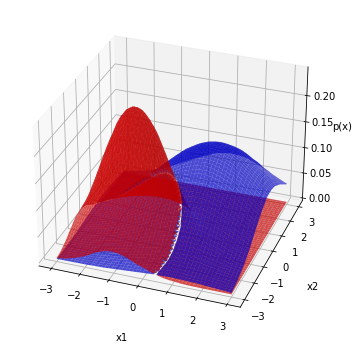

In [25]:
plot()

## Параметрическое востановление плотности

### Принцип максимума правдоподобия

$$
\hat{\theta} = \arg\max_{\theta}L\bigr(\theta, \mathbf{X}^{m}\bigr) = \sum_{i=1}^{m}\ln p\bigr(x_i| \theta\bigr)
$$

Пример для нормального распределения:
$$
\mu = \frac{1}{m}\sum_{i=1}^{m}x_i.
$$

In [8]:
## Наивный байес

In [5]:
wine_data = load_wine()
X = wine_data.data
Y = wine_data.target
print(f"Y shape: {Y.shape}")
print(f"Targets: {wine_data.target_names}")
pd.DataFrame(X, columns=wine_data.feature_names)

Y shape: (178,)
Targets: ['class_0' 'class_1' 'class_2']


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [6]:
X_train, X_test, Y_tarin, Y_test = train_test_split(X, Y, test_size=0.3)

models = []

models.append(GaussianNB())
models.append(MultinomialNB())
models.append(ComplementNB())
models.append(KNeighborsClassifier(n_neighbors=1))
models.append(KNeighborsClassifier(n_neighbors=2))
models.append(KNeighborsClassifier(n_neighbors=3))
models.append(KNeighborsClassifier(n_neighbors=4))

for model in models:
    model.fit(X_train, Y_tarin)
    Y_pred = model.predict(X_test)
    print(f"{model} accuracy: {accuracy_score(Y_pred, Y_test)}")
    


GaussianNB(priors=None, var_smoothing=1e-09) accuracy: 0.9629629629629629
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) accuracy: 0.8703703703703703
ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False) accuracy: 0.6666666666666666
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') accuracy: 0.8148148148148148
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform') accuracy: 0.6296296296296297
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform') accuracy: 0.6851851851851852
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                  

## Нормировка данных

Для реальных данных всегда нужно проводить предварительный анализ данных. В качтности требуется выполнить нормировку данных. Нормировка данных позволяет повысить устойчивость модели при обучении.

In [26]:
X, Y = make_classification(n_samples=150, n_features=2, 
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=40)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=50, 
                                                    random_state=0)

In [27]:
model = SVC(kernel='linear')
_ = model.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.86

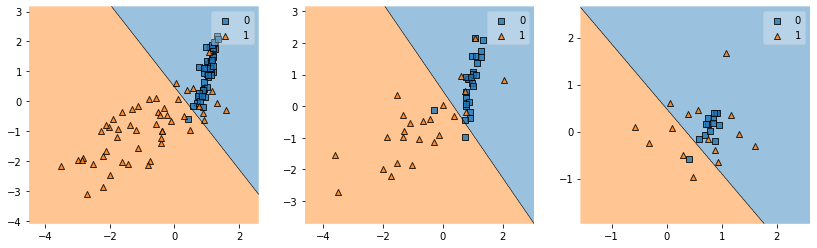

In [28]:
fig, gs = plt.figure(figsize=(14,4)), gridspec.GridSpec(1, 3)

ax = []
for i in range(3):
    ax.append(fig.add_subplot(gs[i]))


plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])
plot_decision_regions(X_train[model.support_], Y_train[model.support_], model, ax=ax[2])

plt.show()

In [2]:
np.random.seed(0)
X, Y = make_classification(n_samples=150, n_features=2, 
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=40)

X = (X + 1000*np.random.randn(1, 2))*1000*np.random.randn(1, 2)
print(X.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=50, 
                                                    random_state=0)

(150, 2)


In [30]:
model = SVC(kernel='linear')
_ = model.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.8

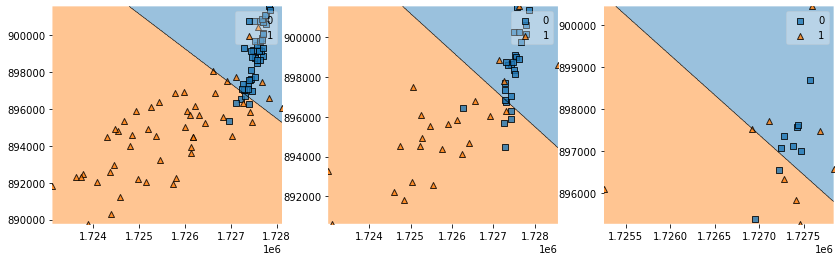

In [31]:
fig, gs = plt.figure(figsize=(14,4)), gridspec.GridSpec(1, 3)

ax = []
for i in range(3):
    ax.append(fig.add_subplot(gs[i]))


plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])
plot_decision_regions(X_train[model.support_], Y_train[model.support_], model, ax=ax[2])

plt.show()

In [32]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

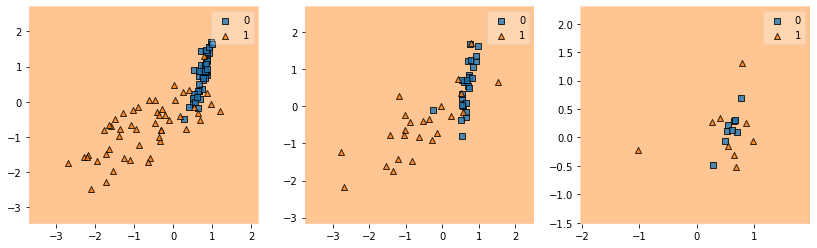

In [33]:
fig, gs = plt.figure(figsize=(14,4)), gridspec.GridSpec(1, 3)

ax = []
for i in range(3):
    ax.append(fig.add_subplot(gs[i]))


plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])
plot_decision_regions(X_train[model.support_], Y_train[model.support_], model, ax=ax[2])

plt.show()

# Ирисы Фишера
Выборка взята отсюда: https://archive.ics.uci.edu/ml/datasets/iris

## Загрузка выборки

In [34]:
dataset = pd.read_csv('data/iris.csv', 
                      header=None, 
                      names=['длина чашелистика', 'ширина чашелистика', 
                             'длина лепестка', 'ширина лепестка', 'класс'])
dataset.sample(5, random_state=0)

,длина чашелистика,ширина чашелистика,длина лепестка,ширина лепестка,класс
114,5.8,2.8,5.1,2.4,Iris-virginica
62,6.0,2.2,4.0,1.0,Iris-versicolor
33,5.5,4.2,1.4,0.2,Iris-setosa
107,7.3,2.9,6.3,1.8,Iris-virginica
7,5.0,3.4,1.5,0.2,Iris-setosa


## Начало работы с данными
1. Определить множество объектов:
    * Определить размер выборки
    * Определить признаки, которыми описываются объекты
2. Определить множество ответов
3. Определить тип задачи машинного обучения
6. ...

### Множество объектов
В данной задачи множество объектов описывается $n=4$ признаками:
1. Длина чашелистика
2. Ширина чашелистика
3. Длина лепестка
4. Ширина лепестка

In [35]:
print('Размер выборки составляет l={} объектов.'.format(len(dataset)))

Размер выборки составляет l=150 объектов.


Все признаки являются вещественными признаками. Формально объекты $\mathbf{X}$ представляються в следующем виде:
$$\mathbf{X} \in \mathbb{R}^{l\times n},$$
где $l$ число объектов, а $n$ число признаков.

Получаем, что $\mathbf{X}$ это некоторая вещественная матрица размера $l\times n$.

### Множество ответов
В данной задаче множество ответов состоит из трех элементов:
1. Iris-virginica
2. Iris-versicolor
3. Iris-setosa

### Задача машинного обучения
В нашем случае, так как мощность множества $|\mathbf{y}|=3 \ll l=150$ получаем задачу классификации на $M=3$ класса.

## Анализ данных
Сначала проэктируем все объекты на двумерные плоскости, для упрощения анализа

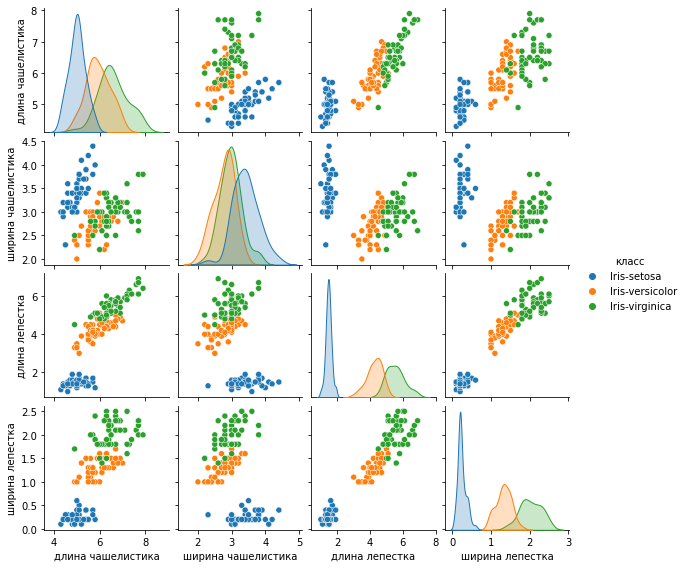

In [36]:
sns.pairplot(dataset, hue='класс', height=2)
plt.show()

Из рисунка видно, что класс синих точек (Iris-setosa) легко отделяется от двух других цветов. Оранжевые и зеленные точки отделяются не так просто в каждой из проэкций, но все равно можно провести прямую, которая отделит оранджевые точки от зеленых.

## Построение модели
### Преобразование данных
Как было сказано ранее нам требуется решить задачу классификации на 3 класса. Но для наглядноси рассмотрим бинарную классификацию (классификацию на несколько классов рассмотрим в следующей лекции).

Чтобы исходную задачу преобразовать в задачу бинарной классификации уберем из выборки все объекта класса Iris-setosa.

In [37]:
binary_dataset = dataset.drop(index=dataset.index[dataset['класс'] == 'Iris-setosa'])

Классы закодируем целыми числами $-1$ и $1$.

In [38]:
binary_dataset.loc[dataset['класс'] == 'Iris-versicolor', dataset.columns == 'класс'] = -1
binary_dataset.loc[dataset['класс'] == 'Iris-virginica', dataset.columns == 'класс'] = 1

Получаем задачу бинарной классификации.

### Модель алгоритмов

Модель алгоритмов $\mathfrak{F}$ в машинном обучении это некоторое множество функций, которые действуют из множества объектов в множество ответов, в нашем случае:
$$\mathfrak{F} = \{f| f: \mathbb{R}^n \to \{-1, 1\}, \text{еще какие-то ограничения}\},$$
обычно $\mathfrak{F}$ это некоторое параметрическое семество функций, тоесть разные функции $f$ отличаются друг от друга только каким-то параметром. Простым примером параметрическим семейством функций для задачи бинарной классификации является семейство линейный классификатор:
$$\mathfrak{F}_{bcl} = \left\{f\bigr(\theta, \mathbf{x}\bigr)=\text{sign}\bigr(\theta^{\mathsf{T}}\mathbf{x}\bigr)\bigr| \theta \in \mathbb{R}^{n} \right\}.$$


### Функция потерь

Машиное обучение это всегда выбор функции из множества $\mathfrak{F}$. Чтобы выбрать функцию, нужен некоторый критерий по которому она выбирается, то есть нужно упоррядочить все функции от худшей к лучшей. Для этого построем функционал $\mathcal{L}$, который каждой функции $f \in \mathfrak{F}$ ставит в соответствии число из $\mathbb{R}_+$. В машинном обучении обычно функционал качества водиться как некоторая ошибка на выборке. В общем виде функционал качества можно представить в следующем виде:
$$\mathcal{L}\bigr(f, \mathbf{X}, \mathbf{y}\bigr) = \sum_{i=1}^l\mathcal{q}\bigr(f, \mathbf{x}_i, y_i\bigr),$$
где $q$ некоторая функция ошибки на некотором объекте $\mathbf{x}$. Функционал качества $\mathcal{L}$ называется эмперическим риском.

### Оптимизационная задача

Далее нужно поставить задачу оптимизации для выбора $f \in \mathfrak{F}$. Здесь все просто, просто минимизируем эмперический риск:
$$\hat{f} = \arg \min_{f \in \mathfrak{F}} \mathcal{L}\bigr(f, \mathbf{X}, \mathbf{y}\bigr).$$

Важно! В результе функция $\hat{f}$ зависит от выборки $\left(\mathbf{X}, \mathbf{y}\right)$, то есть для разных наборов данных оптимальная функция будет различная.

Вернемся к нашей задаче. В нашем случае функционал качества будет иметь следующий вид:
$$\mathcal{L}\bigr(\theta, \mathbf{X}, \mathbf{y}\bigr) = \sum_{i=1}^l\bigr[f\bigr(\theta, \mathbf{x}_i\bigr) \not= y_i\bigr],$$
и оптимизационная задача переписывается в виде:
$$\hat{\theta} = \arg \min_{\theta \in \mathbb{R}^n} \sum_{i=1}^l\bigr[f\bigr(\theta, \mathbf{x}_i\bigr) \not= y_i\bigr].$$

Воспользуемся библиотеками для решения данной задачи. Далее в примере будет найден параметр $\hat{\theta}$ не как решение непосредственно этой оптимизационной задачи, а немного измененной, но об этом позже в следующей лекции.

### Поиск оптимального вектора параметров
Перейдем к двум матрицам:
1. Матрице объектов $\mathbf{X} \in \mathbb{R}^{l\times (n+1)}$
2. Вектору ответов $\mathbf{y} \in \{-1,1\}^l$

Заметим, что объекты мы погрузили в пространство более большой размерности, добавив еще один признак, который у всех объектов будет равен $1$.

In [39]:
X = binary_dataset.iloc[:, binary_dataset.columns != 'класс'].values
y = binary_dataset.iloc[:, binary_dataset.columns == 'класс'].values.reshape(-1)
X = np.array(np.hstack([X, np.ones([len(X), 1])]), dtype=np.float64)
y = np.array(y, dtype=np.int64)

In [40]:
model = LogisticRegression(random_state=0, max_iter=2000)
_ = model.fit(X, y)

Получаем вектор оптимальных параметров $\hat{\theta}$

In [41]:
model.coef_

array([[-3.94426322e-01, -5.13378130e-01,  2.93108661e+00,
         2.41670685e+00, -5.18829562e-04]])

# Переход от бинарной классификации к многоклассовой
Теперь же остается вопрос: как перейти от задачи бинарной классификации к многоклассовой? В качестве бинарного классификатора рассмотрим все ту же модель алгоритмов: 
$$\mathfrak{F}_{bcl} = \left\{f\bigr(\theta, \mathbf{x}\bigr)=\text{sign}\bigr(\theta^{\mathsf{T}}\mathbf{x}\bigr)\bigr| \theta \in \mathbb{R}^{n} \right\}.$$

Но знак позволяет отделить только два знака. Какие же есть решения?

Рассмотрим вариант перехода, который называется Один против всех (One VS All). Для простоты визуализации рассмотрим пример на синтетических данных. 

## Генерация синтетической выборки

In [78]:
np.random.seed(0)
l = 100
n = 2
X1 = np.array([[-1,-1]]) + 0.5*np.random.randn(l, n)
X2 = np.array([[1,1]]) + 0.5*np.random.randn(l, n)
X3 = np.array([[-1,1]]) + 0.5*np.random.randn(l, n)

X = np.vstack([X1, X2, X3])
y = np.hstack([[0]*l, [1]*l, [2]*l])

# Добавляем константу
X = np.hstack([X, np.ones([len(X), 1])])


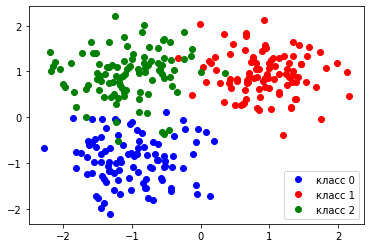

In [79]:
cols = ['blue', 'red', 'green']

# построение точек
for k in np.unique(y):
    plt.plot(X[y==k,0], X[y==k,1], 'o', label='класс {}'.format(k), color=cols[k])

plt.legend(loc='best')
plt.show()

## Один против всех

Данные метод основан на том, что для классификации на $M>2$ классов нужно построить $M$ линейных классификаторов, которые классифицируют $k$-й класс прорив всех остальных классов.

Построим $M=3$ классификатора, которые отделяют каждый класс от двух остальных

In [80]:
models = []
model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==0, dtype=np.int64))
models.append(model)

model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==1, dtype=np.int64))
models.append(model)

model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==2, dtype=np.int64))
models.append(model)

In [81]:
def get_line(a, b, c=0, x_min=-10, x_max=10):
    x1, y1 = -(-models[k].coef_[0][1] + c)/models[k].coef_[0][0], -1
    x2, y2 = -(models[k].coef_[0][1] + c)/models[k].coef_[0][0], 1
    
    polynomial = np.poly1d(np.polyfit([x1, x2], [y1, y2], 1))
    x_axis = np.linspace(x_min, x_max)
    y_axis = polynomial(x_axis)
    
    return x_axis, y_axis

[-0.74102465 -4.10730758 -0.87947999]
[ 4.25046935  0.90205123 -0.87393578]
[-2.53143986  2.57397612 -3.12551399]


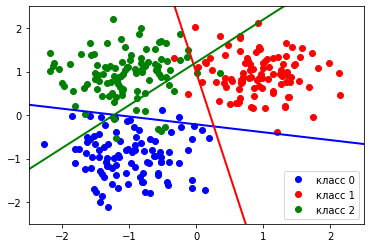

In [82]:
cols = ['blue', 'red', 'green']
plt.xlim((-2.5, 2.5))
plt.ylim((-2.5, 2.5))

for k in np.unique(y):
    plt.plot(X[y==k,0], X[y==k,1], 'o', 
             label='класс {}'.format(k), color=cols[k])

for k in np.unique(y):
    plt.plot(*get_line(*models[k].coef_[0]), linewidth=2, color=cols[k])
    print(models[k].coef_[0])

plt.legend(loc='best')
plt.show()

## Методы анализа качества

Самый простой способо это подсчет ошибок, не верных классов:
$$\mathcal{L}\bigr(\theta, \mathbf{X}, \mathbf{y}\bigr) = \sum_{i=1}^l\bigr[f\bigr(\theta, \mathbf{x}_i\bigr) \not= y_i\bigr].$$

Также можно рассмотреть таблицу попарных ошибок:

|               | y = 1 | y = 2 | y = 3 |
| ------------- | ----- | ----- | ----- |
| __f(x) = 1__  |  1-1  |  1-2  |  1-3  |
| __f(x) = 2__  |  2-1  |  2-2  |  2-3  |
| __f(x) = 3__  |  3-1  |  3-2  |  3-3  |

Данная таблица показывает, сколько классификатор сделал ошибок между двумя парами классов. Например:
1. 2-3 это число, которое обозначает, сколько объектов класса $3$ объект отнес к классу $2$
2. 3-1 это число, которое обозначает, сколько объектов класса $1$ объект отнес к классу $3$

Посчитаем данную матрицу для синтетической выборки.

In [47]:
scores = np.zeros([3,3])
for k in range(3):
    pred = np.argmax(np.vstack([models[i].predict_proba(X[y==k])[:, 1] for i in range(3)]).T, axis=1)
    for i in range(3):
        scores[i, k] = sum(pred == i)
        

In [48]:
print(scores)

[[98.  0.  6.]
 [ 0. 98.  2.]
 [ 2.  2. 92.]]


Результаты данной таблицы показывают такой же результат как и картинка. Хуже всего от других отделим второй класс.

## Servo dataset

In [20]:
numFolds = 10
SEED = 888
np.random.seed(SEED)

colnames = ["motor", "screw", "pgain", "vgain", "class"]
dataset = pd.read_csv("data/servo.data", sep=",", names=colnames)

# Some data preprocessing
X = dataset.drop("class", axis=1)
Y = dataset["class"]
X_conv = pd.get_dummies(X, columns=colnames[:-1])
print(X[0:3])
print(X_conv[0:3])
kf = KFold(numFolds, shuffle=True)

Models = [LinearRegression, SVR]
for Model in Models:
    total = 0
    for train_indices, test_indices in kf.split(X):
        X_train = X_conv.iloc[train_indices, :]
        Y_train = Y[train_indices]
        
        X_test = X_conv.iloc[test_indices, :]
        Y_test = Y[test_indices]

        # Testing out on the linear regression
        reg = Model()
        reg.fit(X_train, Y_train)

        predictions = reg.predict(X_test)
        mse = mean_squared_error(Y_test, predictions)
        total += mse
    
    mse = total / numFolds
    print("Average mse of {0}: {1}", Model.__name__, mse)


  motor screw  pgain  vgain
0     E     E      5      4
1     B     D      6      5
2     D     D      4      3
   motor_A  motor_B  motor_C  motor_D  motor_E  screw_A  screw_B  screw_C  \
0        0        0        0        0        1        0        0        0   
1        0        1        0        0        0        0        0        0   
2        0        0        0        1        0        0        0        0   

   screw_D  screw_E  pgain_3  pgain_4  pgain_5  pgain_6  vgain_1  vgain_2  \
0        0        1        0        0        1        0        0        0   
1        1        0        0        0        0        1        0        0   
2        1        0        0        1        0        0        0        0   

   vgain_3  vgain_4  vgain_5  
0        0        1        0  
1        0        0        1  
2        1        0        0  
Average mse of {0}: {1} LinearRegression 0.7471718771613631
Average mse of {0}: {1} SVR 0.5885072250062546
